In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from random import sample

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

import pygame
import Maze_Solver as maze_solver
from Maze_Solver import MazeSolver, MazeSolverEnv
import Maze_Generator as maze_generator

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# cuda가 설치되어 있다면 cuda를 사용하고 아니라면 cpu만을 사용한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class qnet(nn.Module):
    def __init__(self, h, w, outputs):
        super(qnet, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm1d(4) # 4 actions
        self.tanh = nn.Tanh()
        
        # torch.log makes nan(not a number) error so we have to add some small number in log function
        self.ups=1e-7

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 3, stride = 1):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        
        self.fc1 = nn.Linear(linear_input_size, outputs)
        self.head = nn.Softmax(dim=1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        
        return self.head(x)

    def greedy_action(self, state):
        state = torch.tensor(state)
        state = torch.unsqueeze(state, 0)
        probs = self.forward(state)
        probs = torch.squeeze(probs, 0)
        action = torch.tensor([torch.argmax(probs)])
        action = action.data
        action = action[0]
        
        return action
    
    def epsilon_greedy_action(self, state, epsilon = 0.1):
        state = torch.tensor(state)
        state = torch.unsqueeze(state, 0)
        probs = self.forward(state)
        
        probs = torch.squeeze(probs, 0)
        
        if random.random() > epsilon:
            action = torch.tensor([torch.argmax(probs)])
        else:
            action = torch.rand(probs.shape).multinomial(num_samples=1)
        
        action = action.data
        action = action[0]
        return action
        
    def q_value(self, s, a):
        s = torch.tensor(s)
        s = torch.unsqueeze(s, 0)
        value = self.forward(s)
        value = torch.squeeze(value, 0)
        
        return value[a]
    
def update_weight(qnet, optimizer, states, actions, dones, rewards):
    
    for t, (s_t, a_t, done, r_tt) in enumerate(list(zip(states, actions, dones, rewards))):
        r_tt = torch.tensor(r_tt)
        if done == 1:
            loss = r_tt + GAMMA * torch.max(qnet.forward(states[t+1])) - qnet.q_value(s_t, a_t)
        else:
            loss = r_tt - qnet.q_value(s_t, a_t)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)

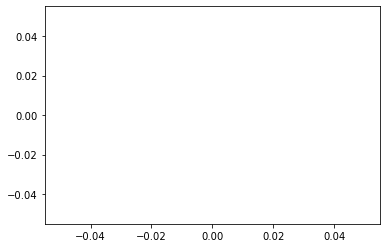

In [4]:
MAX_EPISODES = 10000
MAX_TIMESTEPS = 1000

ALPHA = 3e-4 # learning rate
GAMMA = 0.99 # step-size
batch_size = 100

env = MazeSolverEnv()

num_actions = env.num_action
num_states = env.num_obs

DQN = qnet(num_states[0], num_states[1], num_actions).to(device)

optimizer = optim.Adam(DQN.parameters(), lr=ALPHA)

try:
    returns = []
    
    for i_episode in range(MAX_EPISODES):

        state = env.init_obs
        init_state = state
        
        #state = env.init_obs
        done = False
        
        dones = [] # if not done, then 1 else 0
        states = []
        actions = []
        rewards = [0]   # no reward at t = 0

        #while not done:
        for timesteps in range(MAX_TIMESTEPS):
            states.append(state)
            
            action = DQN.epsilon_greedy_action(state)
            actions.append(action)
            
            state, reward, done, _ = env.step(action.tolist())
            
            rewards.append(reward)

            if done or timesteps == MAX_TIMESTEPS-1:
                states.append(state)
                actions.append(action)
                dones.append(1 if not done else 0)
                break
        
        update_weight(DQN, optimizer, states, actions, dones, rewards)
        
        #====================================================================================================
        #to see the change of the weights====================================================================
        #====================================================================================================
        print("=========================================================================================")
        print("DQN.fc1.weight : {}".format(DQN.fc1.weight))
        #====================================================================================================

        if (i_episode + 1) % 500 == 0:
            print("Episode {} return {}".format(i_episode + 1, sum(rewards)))
            torch.save(DQN, './saved_models/DQN' + str(i_episode + 1) + '.pt')
        elif (i_episode + 1) % 10 == 0:
            print("Episode {} return {}".format(i_episode + 1, sum(rewards)))
            
        returns.append(sum(rewards))
        env.reset_player(exploring_starts = False)

except KeyboardInterrupt:
    plt.plot(range(len(returns)), returns)
finally:
    plt.plot(range(len(returns)), returns)

env.close()
